# Quicklook program for EAGLE

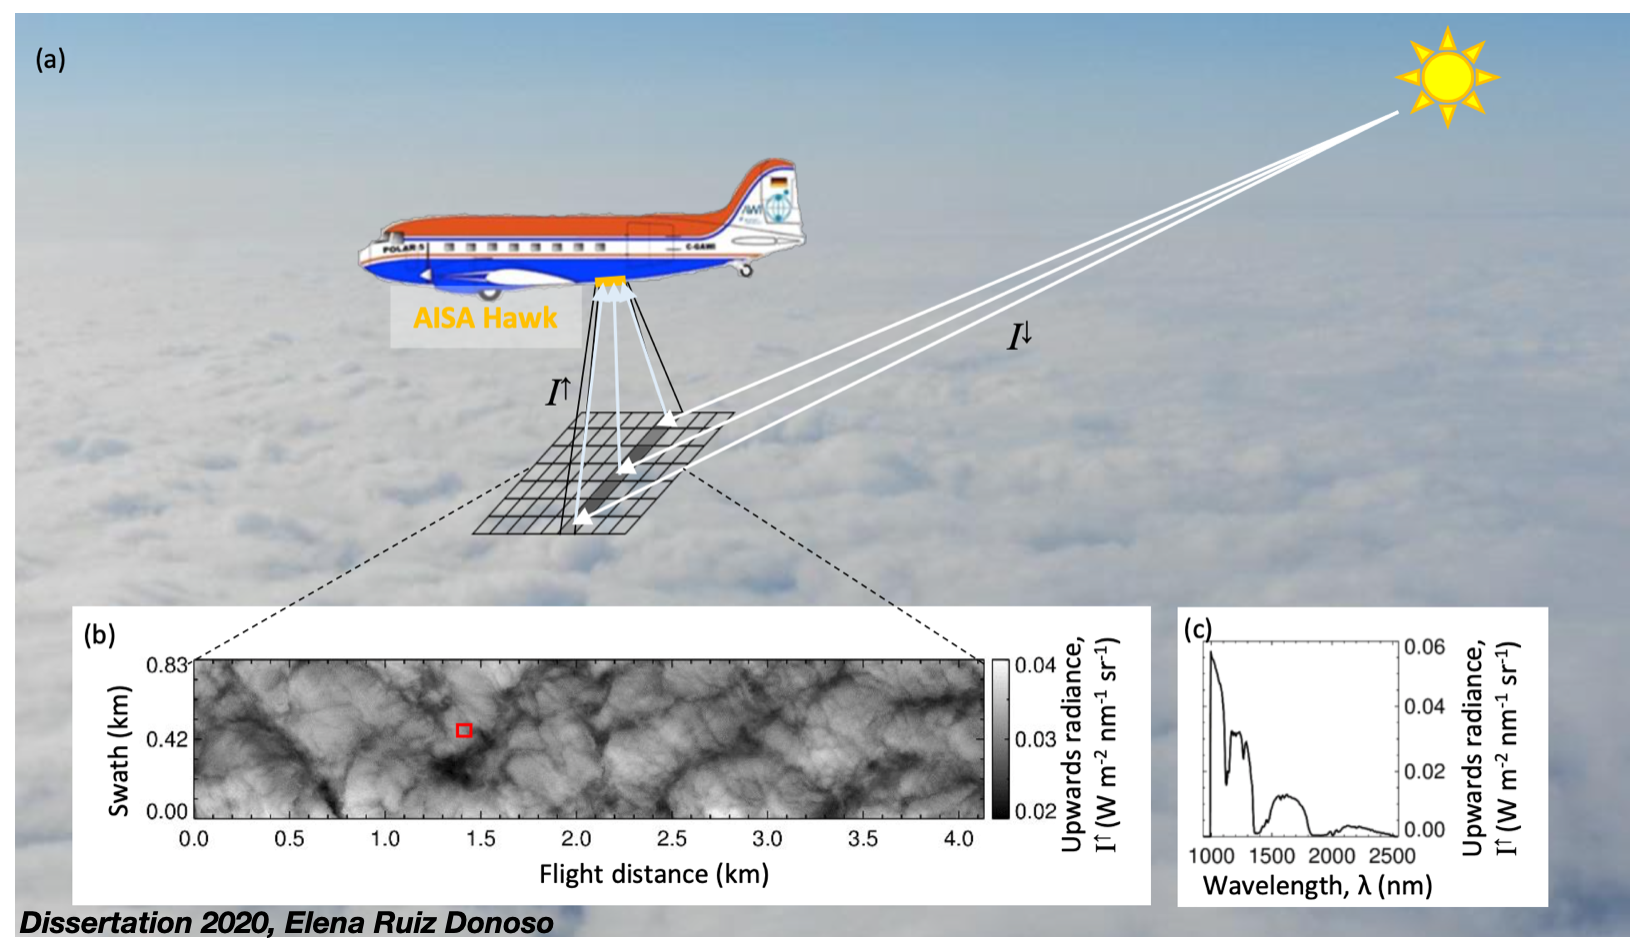

In [21]:
from PIL import Image
Image.open('ExplHawk.png')

## Import modules

In [19]:
from spectral import *
import numpy as np
from tqdm import tqdm_notebook as tqdm 
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import glob
import matplotlib.dates as mdates
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

## Settings

In [14]:
#Input folder
input_folder = "/Users/marcusklingebiel/Documents/Campaigns/HALO_AC3/Quicklook_Programs/raw_data/EAGLE_MOSAiC-ACA/"

#wavelength(s)
wvl = [640] #between 400 und 993nm

wvl_image = [630,532,465]

#Output folder
output_folder= "/Users/marcusklingebiel/Documents/Campaigns/HALO_AC3/Quicklook_Programs/processed_data/EAGLE/"


#Plots settings
PlotImage = True
PlotArray = True
PlotSpec  = True

## Some functions

In [15]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def Plot_RGB_image(arr, time,filename):
    rgb_arr = np.zeros(shape = (np.shape(arr)[0],np.shape(arr)[1], 3))

    for i in range(0,(np.shape(arr)[0])):
        rgb_arr[i,:,0]= arr[i,:,idx1]
        rgb_arr[i,:,1]= arr[i,:,idx2]
        rgb_arr[i,:,2]= arr[i,:,idx3]

    rgb_arr[:,:,0] = rgb_arr[:,:,0]/np.nanmax(rgb_arr[:,:,0]) * 255
    rgb_arr[:,:,1] = rgb_arr[:,:,1]/np.nanmax(rgb_arr[:,:,1]) * 255
    rgb_arr[:,:,2] = rgb_arr[:,:,2]/np.nanmax(rgb_arr[:,:,2]) * 255    

    rgb_arr_1 = np.swapaxes(rgb_arr,0,1)
    rgb_img = Image.fromarray(rgb_arr_1.astype(np.uint8),"RGB")


    fs = 14
    plt.rcParams.update({'font.size': fs})
    x_lims = list(map(datetime.fromtimestamp, [time[0].timestamp(), time[len(time)-1].timestamp()]))
    x_lims = mdates.date2num(x_lims)
    fig, ax = plt.subplots(figsize = (12,4))
    ax.imshow(rgb_img,aspect = "auto", origin="lower",extent = [x_lims[0], x_lims[1],0,1024])
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    ax.xaxis_date()
    ax.set_xlabel("UTC time")
    ax.set_ylabel("across-track-pixel")

    plt.savefig(filename,dpi=300,bbox_inches="tight")
    plt.close()

## List all available files

In [16]:
list_of_files = sorted(glob.glob(input_folder+"*.hdr"))
list_of_files 

['/Users/marcusklingebiel/Documents/Campaigns/HALO_AC3/Quicklook_Programs/raw_data/EAGLE_MOSAiC-ACA/MOSAiC_ACA_Flight_20200902a_0902-0758.hdr',
 '/Users/marcusklingebiel/Documents/Campaigns/HALO_AC3/Quicklook_Programs/raw_data/EAGLE_MOSAiC-ACA/MOSAiC_ACA_Flight_20200902a_0902-0801.hdr',
 '/Users/marcusklingebiel/Documents/Campaigns/HALO_AC3/Quicklook_Programs/raw_data/EAGLE_MOSAiC-ACA/MOSAiC_ACA_Flight_20200902a_0902-0804.hdr',
 '/Users/marcusklingebiel/Documents/Campaigns/HALO_AC3/Quicklook_Programs/raw_data/EAGLE_MOSAiC-ACA/MOSAiC_ACA_Flight_20200902a_0902-0807.hdr']

## Main program starts here

In [20]:
for i in tqdm(range(0,len(list_of_files))):
    filename = list_of_files[i][-41:-4]
    print(filename)
    img = open_image(list_of_files[i])
    b = img.bands.centers
    arr= img.asarray()
    
    #Get time
    date = img.metadata['acquisition date'][-10:]
    date = date[-4:]+"-"+date[-7:-5]+"-"+date[-10:-8]
    start_time = img.metadata['gps start time'][-13:-1]
    if PlotArray == True:
        starttime = datetime.fromisoformat(date+" "+start_time)
        #print(starttime)
    
        time_ls  = []

        for i in range(0,len(arr)):
            time_ls.append(starttime + i* timedelta(seconds=0.05))
        time = np.asarray(time_ls)
        
        
    #Plot picture for all wavelengths
    for j in range(len(wvl)):
        #find nearest wavelength
        idx = find_nearest(b,wvl[j])
        
        #print(b[idx], idx)
        
        if PlotImage == True:
            idx1 = find_nearest(b,wvl_image[0])
            idx2 = find_nearest(b,wvl_image[1])
            idx3 = find_nearest(b,wvl_image[2])
            save_rgb(output_folder+filename+"_"+str(wvl[j])+'.jpg', img, [idx1, idx2 , idx3])
      

        #Plot array
        if PlotArray == True:
            #print(len(time),np.shape(arr))
            _,ax = plt.subplots(figsize=(round(len(time)/1024),1))
            ax.contourf(time,np.arange(0,1024),arr[:,:,idx].T,25,cmap="Greys_r")
        
            
            #find points for spectra
            if PlotSpec == True:
                round(len(arr)/5)
                ls_spec_pts = []
                for i in range(1,5):
                    ls_spec_pts.append((i*round(len(arr)/5)))

                for i in range(len(ls_spec_pts)):
                    ax.scatter(time[ls_spec_pts[i]],1024/2)
            ax.set_xlabel("Time (UTC)")
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
            ax.tick_params(axis='x', rotation=45)
            ax.set_yticks(np.arange(0,1024,250))
            ax.set_ylabel("across-track-pixel")
            plt.savefig(output_folder+filename+"_"+str(wvl[j])+'_arr.png',dpi=300,bbox_inches="tight")
            plt.close()

        
        #Plot image with axes
        Plot_RGB_image(arr,time,output_folder+filename+"_"+str(wvl[j])+'_img.png')
        Plot_RGB_image(arr[:1000,:,:],time[:1000],output_folder+filename+"_"+str(wvl[j])+'_img_large.png')
        

        #Plot spectrum
        if PlotSpec == True:
            for i in range(len(ls_spec_pts)):
                plt.plot(b,arr[ls_spec_pts[i],500,:]/100*0.01)
            plt.grid(linestyle=":")
            plt.xlabel("Wavelength (nm)")
            plt.ylabel("Radiance ($W~m^{-2}~sr^{-1}~nm^{-1}$)")
            plt.savefig(output_folder+filename+"_"+str(wvl[j])+'_spec.png',dpi=300,bbox_inches="tight")
            plt.close()

MOSAiC_ACA_Flight_20200902a_0902-0758
MOSAiC_ACA_Flight_20200902a_0902-0801
MOSAiC_ACA_Flight_20200902a_0902-0804
MOSAiC_ACA_Flight_20200902a_0902-0807

